# Comparing Illumina and AVITI sequencing

Pooled sequencing was performed on bacterial samples from two donors. Identical pools were prepared using Illumina and, later, AVITI. The following metrics were used to compare Illumina and AVITI:

- Total number of reads
- Fragment quality
- Sequence-typing results
- Constructed phylogenies

Only *E. coli* samples from only one of the donors (baby 2; `B002`) (52.6% of total samples in the pool) were used for these metrics.

## Preamble

In [1]:
import os
from contextlib import ContextDecorator
from pathlib import Path

import duckdb
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import snakemake

In [24]:
# Matplotlib config

from matplotlib import font_manager

for font_file in font_manager.findSystemFonts(
    fontpaths=f'{os.environ['GROUP_HOME']}/fonts'
):
    font_manager.fontManager.addfont(font_file)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'

cmap = plt.get_cmap('Set1')
pal = {'AVITI': cmap(0), 'Illumina': cmap(1)}

In [3]:
# convenience functions

class results(ContextDecorator):
    def __init__(self, db):
        self.db = db
        
    def __enter__(self):
        self.con = duckdb.connect(database=self.db, read_only=True)
        return self.con

    def __exit__(self, *exc):
        self.con.close()
        return False

    def __call__(self, func):
        def wrapper(*args, **kwargs):
            with self as con:
                return func(con, *args, **kwargs)
        return wrapper

In [4]:
# results_db = '../../results/results.duckdb'
# figures_dir = '../../report/figures'

results_db = snakemake.params.get('db')
figures_dir = snakemake.params.get('fdir')

figures_dir = Path(figures_dir)
figures_dir.mkdir(parents=True, exist_ok=True)

check which tables present in results

In [5]:
@results(results_db)
def show_tables(con):
    print(con.sql('show tables;'))

show_tables()

┌─────────────────────────────────┐
│              name               │
│             varchar             │
├─────────────────────────────────┤
│ bcftools_variant_quality_scores │
│ fastp_read_counts               │
│ samplesheet                     │
│ sequence_typing_results         │
└─────────────────────────────────┘



## Results

### Total number of reads

In [6]:
@results(results_db)
def get_total_reads_plotting_data(con):
    query = '''
    unpivot (
        select
            samples.ID
            , samples.group as sequencing
            , reads.before_filtering_total_reads as before
            , reads.after_filtering_total_reads as after
        from fastp_read_counts reads
        left join samplesheet samples
        on reads."sample" = samples."sample"
    )
    on before, after
    into 
        name filtering
        value n_reads
    ;
    '''
    return con.sql(query).df()

In [9]:
tot_reads_data = get_total_reads_plotting_data()

tot_reads_data_plt = (
    tot_reads_data
    .groupby(['sequencing', 'filtering'])
    .agg({'n_reads': 'sum'})
    .reset_index()
    .assign(
        n_reads=lambda df: df['n_reads'].div(10**9),
        Sequencing=lambda df: df['sequencing'].replace({'aviti': 'AVITI', 'illumina': 'Illumina'}),
    )
    .rename(columns={'n_reads': r'Total reads (x $10^9$)', 'filtering': 'Filtering'})
)

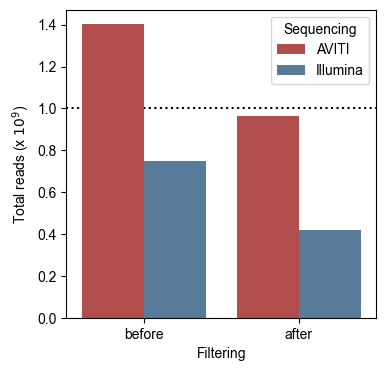

In [25]:
fig, ax = plt.subplots(figsize=(4, 4))

sns.barplot(
    data=tot_reads_data_plt,
    x='Filtering',
    y=r'Total reads (x $10^9$)',
    hue='Sequencing',
    palette=pal,
    saturation=.5,
    order=['before', 'after'],
    ax=ax,
)

ax.axhline(1, ls=':', color='k', zorder=-1)

for ext in ['pdf', 'png']:
    fig.savefig(figures_dir / f'total_reads.{ext}', bbox_inches='tight')

### Fragment quality

In [13]:
@results(results_db)
def get_variant_quality_plotting_data(con):
    query = '''
    select
        samples.group
        , samples.ID
        , quals.quality
        , quals.count
    from bcftools_variant_quality_scores quals
    left join samplesheet samples
    on quals."sample" = samples."sample"
    ;
    '''
    return con.sql(query).df()

In [14]:
variant_qual_data = get_variant_quality_plotting_data()

variant_qual_data_plt = (
    variant_qual_data
    .eval('quality_wt = quality * count')
    .groupby(['group', 'ID'])
    .agg({
        'count': 'sum',
        'quality_wt': 'sum',
    })
    .eval('Qual = quality_wt / count')
    .reset_index()
    .assign(
        Sequencing=lambda df: df['group'].replace({'aviti': 'AVITI', 'illumina': 'Illumina'}),
    )
)

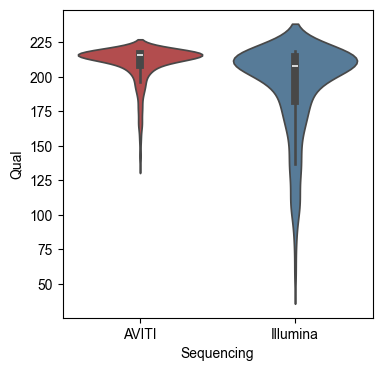

In [26]:
fig, ax = plt.subplots(figsize=(4, 4))

sns.violinplot(
    data=variant_qual_data_plt,
    x='Sequencing',
    y='Qual',
    hue='Sequencing',
    palette=pal,
    saturation=.5,
    ax=ax,
)

for ext in ['pdf', 'png']:
    fig.savefig(figures_dir / f'variant_quality_scores.{ext}', bbox_inches='tight')

### Sequence-typing results

- overall results
- frequency of conflicting assignments

In [68]:
@results(results_db)
def get_sequence_typing_plotting_data(con):
    query = '''
    select
        * exclude("sample")
    from sequence_typing_results st
    left join samplesheet samples
    on st."sample" = samples."sample"
    where st >= 0;
    '''
    return con.sql(query).df()

In [69]:
seqtype_data = get_sequence_typing_plotting_data()

# Encode sequence types for plotting using `pandas.factorize`
seqtype_data = seqtype_data.sort_values('st')
seqtype_data['st_codes'], st_cats = pd.factorize(seqtype_data['st'])

# Encode sequencing type
pd.set_option('future.no_silent_downcasting', True)
seqtype_data['group_codes'] = seqtype_data['group'].replace({'aviti': .25, 'illumina': -.25})

# Parse x coords
plot_data = (
    seqtype_data
    .query("st_codes >= 0")
    .assign(xvals=lambda df: df['st_codes'] + df['group_codes'])
)

# Pair obs from same sample
plot_data_piv = (
    plot_data
    .pivot_table(
        index='ID',
        columns='group',
        # values=['st', 'depth', 'maxMAF']
        values=['xvals', 'depth']
    )
)

/tmp/ipykernel_127641/2370837281.py:3: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(
/tmp/ipykernel_127641/2370837281.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(


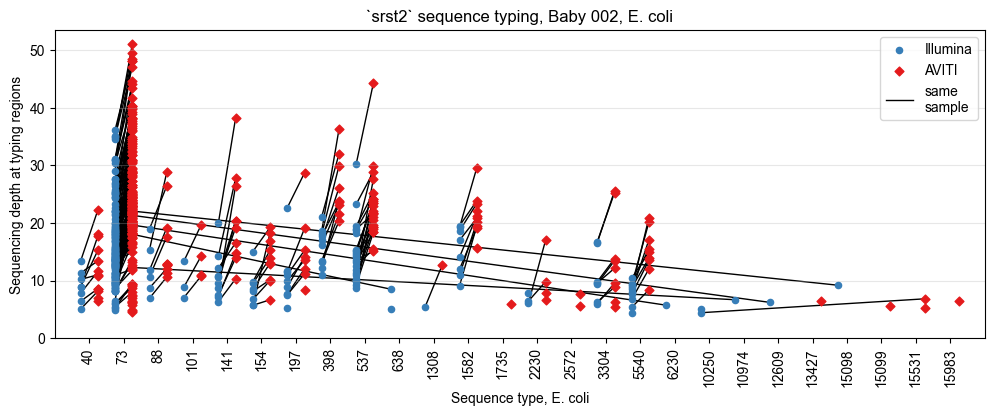

In [70]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.scatter(
    plot_data.query("group == 'illumina'")['xvals'],
    plot_data.query("group == 'illumina'")['depth'],
    c=pal['Illumina'],
    zorder=0, 
    marker='o',
    s=20,
    label='Illumina',
)

ax.scatter(
    plot_data.query("group == 'aviti'")['xvals'],
    plot_data.query("group == 'aviti'")['depth'],
    c=pal['AVITI'],
    zorder=0,
    marker='D',
    s=20,
    label='AVITI',
)

for row in plot_data_piv.iterrows():
    ax.plot(row[1]['xvals'], row[1]['depth'], c='k', ls='-', lw=1, zorder=-1)

ax.plot(1, 1, c='k', ls='-', lw=1, label='same\nsample') # Hacky, for legend
ax.set_xlim(-1, st_cats.astype(int).size)
ax.set_ylim(0, None)

ax.set_xticks(
    list(range(st_cats.astype(int).size)),
    st_cats.astype(int),
    rotation='vertical',
)

ax.set_title('`srst2` sequence typing, Baby 002, E. coli')
ax.set_xlabel('Sequence type, E. coli')
ax.set_ylabel('Sequencing depth at typing regions')

ax.grid(visible=True, alpha=.3, zorder=-2, axis='y')
ax.legend()

for ext in ['pdf', 'png']:
    fig.savefig(figures_dir / f'sequence_typing.{ext}', bbox_inches='tight')

In [121]:
seqtype_agreement = (
    seqtype_data
    .pivot_table(
        index='ID',
        columns='group',
        values='st'
    )
    .eval("both_agree = aviti == illumina")
    .assign(both_typed=lambda df: df['aviti'].isnull() == df['illumina'].isnull())
)

In [156]:
(
    pd.DataFrame(
        {
            'AVITI \\& Illumina (total)': seqtype_agreement.shape[0],
            'AVITI, typed (total)': seqtype_agreement['aviti'].dropna().shape[0],
            'Illumina, typed (total)': seqtype_agreement['illumina'].dropna().shape[0],
            'AVITI \\& Illumina, typed (total)': seqtype_agreement.query("both_typed").shape[0],
            'AVITI \\& Illumina, typed (agree)': seqtype_agreement.query("both_typed & both_agree").shape[0],
        },
        index=pd.Index(['Count'], name='')
    )
    .transpose()
    .to_latex(figures_dir / f'sequence_typing_table.tex')
)

### Constructed phylogenies